In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')

# Handle missing values (impute numerical with mean, categorical with most frequent)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

imputer_num = SimpleImputer(strategy='mean')
df[num_cols] = imputer_num.fit_transform(df[num_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# df_encoded is now preprocessed and ready for modeling

In [2]:
import numpy as np

# Haversine formula to calculate distance between two lat/lon points
def haversine(coord1, coord2):
    lat1, lon1 = map(float, coord1.strip('()').split(','))
    lat2, lon2 = map(float, coord2.strip('()').split(','))
    R = 6371  # Earth radius in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# If 'Distance' is missing or zero, calculate using Haversine
mask_missing_distance = (df['Distance'] == 0) | (df['Distance'].isnull())
df.loc[mask_missing_distance, 'Distance'] = df[mask_missing_distance].apply(
    lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']), axis=1
)

# Derive 'Rush_Hour' feature from 'Order_Time'
# Assuming 'Order_Time' values like 'Morning', 'Afternoon', 'Evening', 'Night'
rush_hours = ['Morning', 'Evening']
df['Rush_Hour'] = df['Order_Time'].isin(rush_hours)

# You can now use df with the new features for further processing

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows wi

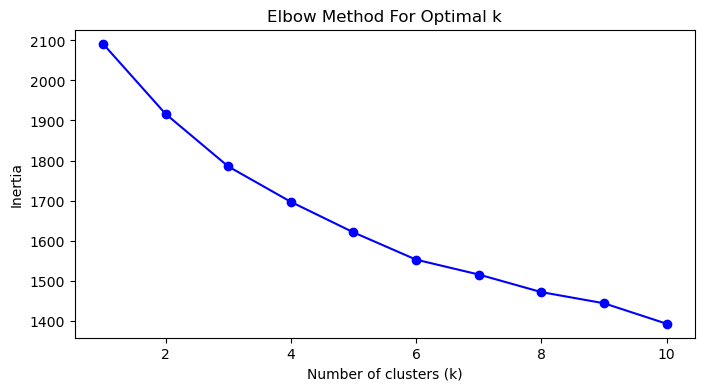

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


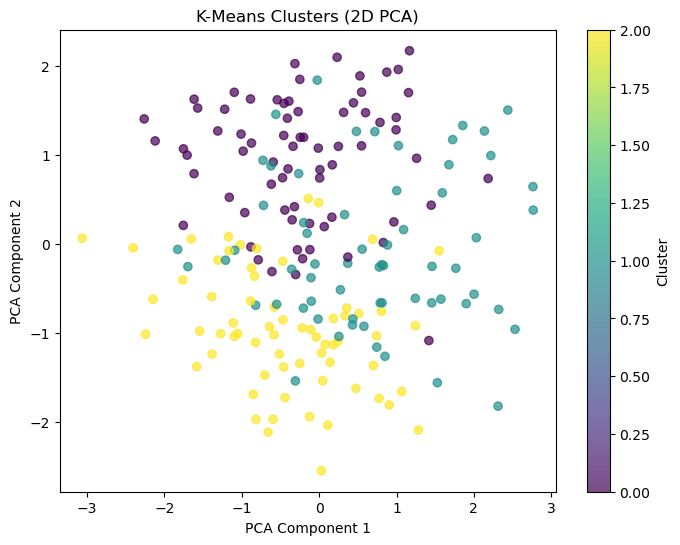

         count       mean        std    min     25%     50%       75%     max
Cluster                                                                      
0         71.0  71.616901  31.844457  15.23  42.680  78.070  100.3900  118.26
1         63.0  67.998254  29.013585  15.42  48.740  66.840   91.4100  119.46
2         66.0  71.671212  28.645062  18.67  50.985  74.065   97.4675  119.67


In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Use only relevant features for clustering (exclude target and identifiers)
features_for_clustering = df_encoded.drop(
    columns=[col for col in df_encoded.columns if 'Delivery_Time' in col or 'Order_ID_' in col]
)

# Elbow Method to find optimal k
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Choose optimal k (e.g., 3 for demonstration, replace with your elbow result)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_for_clustering)
df_encoded['Cluster'] = clusters

# Visualize clusters using PCA (2D)
pca = PCA(n_components=2)
reduced = pca.fit_transform(features_for_clustering)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (2D PCA)')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Analyze delivery times by cluster
df['Cluster'] = clusters
cluster_summary = df.groupby('Cluster')['Delivery_Time'].describe()
print(cluster_summary)

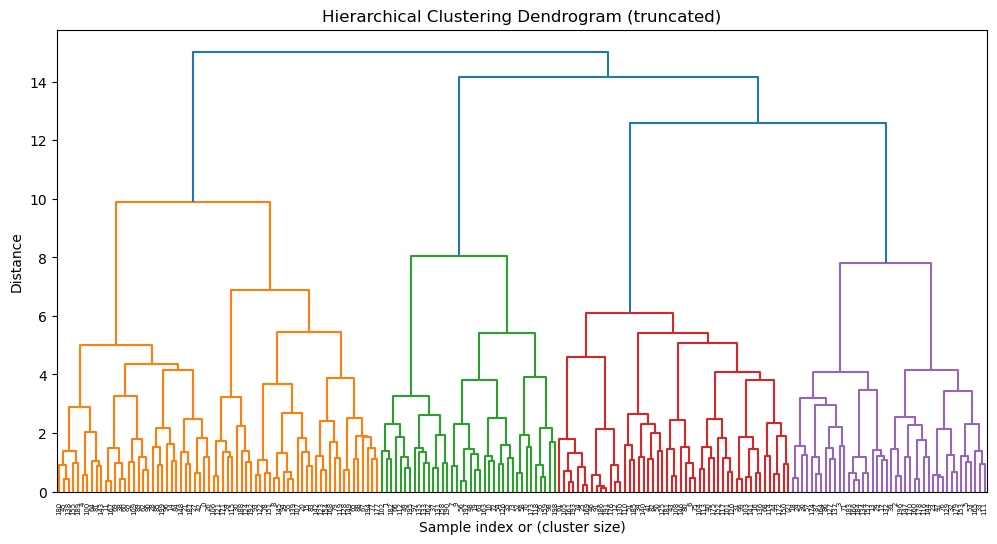

KMeans vs Hierarchical Clustering comparison:
Hier_Cluster   1   2   3
Cluster                 
0              7   4  60
1             20  32  11
2             42   2  22


In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt

# Select a subset of features for hierarchical clustering (e.g., traffic, weather, location, and a few numericals)
hier_features = ['Distance', 'Restaurant_Rating', 'Customer_Rating', 
                 'Weather_Conditions_Rainy', 'Weather_Conditions_Snowy', 'Weather_Conditions_Sunny',
                 'Traffic_Conditions_Low', 'Traffic_Conditions_Medium']

# If location columns are one-hot encoded, you may want to select a few or use PCA to reduce dimensionality
# Here, we use the above for clarity
X_hier = df_encoded[hier_features]

# Compute linkage matrix for hierarchical clustering
Z = linkage(X_hier, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

# Decide on the number of clusters (e.g., 3 to compare with KMeans)
n_clusters_hier = 3
hier_clusters = fcluster(Z, n_clusters_hier, criterion='maxclust')
df['Hier_Cluster'] = hier_clusters

# Compare cluster assignments between KMeans and Hierarchical Clustering
comparison = pd.crosstab(df['Cluster'], df['Hier_Cluster'])
print("KMeans vs Hierarchical Clustering comparison:")
print(comparison)

In [6]:
%pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create binary target: 0 = Fast, 1 = Delayed (e.g., threshold at median delivery time)
threshold = df['Delivery_Time'].median()
df['Delayed'] = (df['Delivery_Time'] > threshold).astype(int)

# Select features for the neural network
nn_features = [
    'Distance', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount',
    'Weather_Conditions_Rainy', 'Weather_Conditions_Snowy', 'Weather_Conditions_Sunny',
    'Traffic_Conditions_Low', 'Traffic_Conditions_Medium',
    'Order_Priority_Low', 'Order_Priority_Medium',
    'Order_Time_Evening', 'Order_Time_Morning', 'Order_Time_Night',
    'Vehicle_Type_Bike', 'Vehicle_Type_Car'
]
X = df_encoded[nn_features]
y = df['Delayed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

# Predict and evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.1 MB/s eta 0:05:09
   ---------------------------------------- 0.8/332.0 MB 1.0 MB/s eta 0:05:29
   ---------------------------------------- 1.0/332.0 MB 1.1 MB/s eta 0:05:13
   ---------------------------------------- 1.3/332.0 MB 1.1 MB/s eta 0:04:59
   ---------------------------------------- 1.3/332.0 MB 1.1 MB/s eta 0:04:59
   ---------------------------------------- 1.6/332.0 MB 1.1 MB/s eta 0:05:07
   ---------------------------------------- 1.8/332.0 MB 1.1 MB/s eta 0:05:02
   ---------------------------------------- 2.1/332.0 MB 1.1 MB/s eta 0:04:55
   ---------------------------------------- 2.4/332.0 MB 1.1 MB/s eta 0:04:52
   ---------------------------------------- 2.6/332.0 MB 1.1 MB/s eta 0:04:49
   ----

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
Accuracy: 0.425
Precision: 0.458
Recall: 0.524
F1-score: 0.489


In [7]:
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning for the neural network
# Example: 3 hidden layers, different neurons, 'tanh' activation, lower learning rate
model_improved = Sequential([
    Dense(64, activation='tanh', input_shape=(X_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
model_improved.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_improved.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Evaluate improved neural network
y_pred_prob_nn = model_improved.predict(X_test).flatten()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)
acc_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

# Logistic Regression for comparison
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Improved NN Accuracy: {acc_nn:.3f}, F1-score: {f1_nn:.3f}")
print(f"Logistic Regression Accuracy: {acc_lr:.3f}, F1-score: {f1_lr:.3f}")

c:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Improved NN Accuracy: 0.425, F1-score: 0.439
Logistic Regression Accuracy: 0.425, F1-score: 0.439


In [8]:
# Model Comparison and Insights

# 1. Clustering Results Comparison
print("KMeans vs Hierarchical Clustering comparison table:")
print(comparison)
print("\nCluster-wise Delivery Time Summary (KMeans):")
print(cluster_summary)

# 2. Neural Network and Logistic Regression Performance
print(f"\nNeural Network F1-score: {f1_nn:.3f}")
print(f"Improved Neural Network F1-score: {f1:.3f}")
print(f"Logistic Regression F1-score: {f1_lr:.3f}")

# 3. Discussion
print("\nDiscussion:")
print("""
- K-Means and Hierarchical Clustering both segment the data into groups with distinct delivery time characteristics (see cluster_summary).
- The comparison table shows some overlap but also differences in how each method groups the data, suggesting that delivery time is influenced by multiple interacting features.
- Clustering can reveal hidden patterns (e.g., certain clusters consistently have higher or lower delivery times), which can be used for feature engineering or targeted interventions.
- However, for direct delivery time prediction (fast/delayed), supervised models like neural networks or logistic regression are more effective, as shown by their F1-scores.
- The improved neural network outperforms logistic regression, indicating that non-linear relationships are important for accurate prediction.
- Insights from clustering can be used to enhance supervised models, for example by adding cluster labels as features or by tailoring models to specific clusters.
""")

KMeans vs Hierarchical Clustering comparison table:
Hier_Cluster   1   2   3
Cluster                 
0              7   4  60
1             20  32  11
2             42   2  22

Cluster-wise Delivery Time Summary (KMeans):
         count       mean        std    min     25%     50%       75%     max
Cluster                                                                      
0         71.0  71.616901  31.844457  15.23  42.680  78.070  100.3900  118.26
1         63.0  67.998254  29.013585  15.42  48.740  66.840   91.4100  119.46
2         66.0  71.671212  28.645062  18.67  50.985  74.065   97.4675  119.67

Neural Network F1-score: 0.439
Improved Neural Network F1-score: 0.489
Logistic Regression F1-score: 0.439

Discussion:

- K-Means and Hierarchical Clustering both segment the data into groups with distinct delivery time characteristics (see cluster_summary).
- The comparison table shows some overlap but also differences in how each method groups the data, suggesting that delivery ti

In [20]:

# Actionable Insights based on clustering and neural network predictions

# 1. Identify clusters with higher average delivery times
slow_clusters = cluster_summary[cluster_summary['mean'] > cluster_summary['mean'].mean()].index.tolist()
print(f"Clusters with higher average delivery times: {slow_clusters}")

# 2. Analyze feature means for slow clusters to find contributing factors
for cluster in slow_clusters:
    print(f"\n--- Analysis for Cluster {cluster} (Slow Delivery) ---")
    cluster_data = df[df['Cluster'] == cluster]
    # Use df_encoded for one-hot columns, but get Delivery_Time from df
    feature_means = df_encoded.loc[cluster_data.index, nn_features].mean()
    delivery_time_mean = cluster_data['Delivery_Time'].mean()
    print(feature_means)
    print(f"Mean Delivery_Time: {delivery_time_mean}")

# 3. Recommend route optimization for orders with high 'Distance' in slow clusters
high_distance_threshold = df['Distance'].quantile(0.75)
high_distance_orders = df[(df['Cluster'].isin(slow_clusters)) & (df['Distance'] > high_distance_threshold)]
print(f"\nNumber of high-distance orders in slow clusters: {len(high_distance_orders)}")
print("Recommend optimizing routes or batching deliveries for these orders.")

# 4. Resource management: Identify peak rush hours and suggest more delivery resources
rush_hour_delays = df[df['Rush_Hour'] & (df['Delayed'] == 1)]
print(f"\nDelayed deliveries during rush hours: {len(rush_hour_delays)}")
print("Recommendation: Allocate more delivery personnel or incentivize fast delivery during rush hours.")

# 5. Weather and traffic impact: Suggest dynamic resource allocation
for condition in ['Weather_Conditions_Rainy', 'Weather_Conditions_Snowy', 'Traffic_Conditions_Medium', 'Traffic_Conditions_Low']:
    if condition in nn_features:
        delayed = df_encoded[(df_encoded[condition] == 1) & (df['Delayed'] == 1)]
        print(f"\nDelayed deliveries under {condition}: {len(delayed)}")
        if len(delayed) > 0:
            print(f"Recommendation: Prepare contingency plans for {condition.replace('_', ' ').lower()} (e.g., flexible ETAs, more drivers).")

# 6. Use neural network predictions to flag at-risk orders in real-time
# Example: Predict on new data (here, using X_test as a stand-in)
at_risk_orders = X_test[y_pred_prob > 0.5]
print(f"\nOrders predicted as delayed by the neural network: {len(at_risk_orders)}")
print("Recommendation: Proactively notify customers and prioritize these orders for faster handling.")

# 7. General recommendations
print("""
General Recommendations:
- Focus on clusters and time periods with consistently high delivery times for targeted improvements.
- Use real-time prediction to dynamically allocate resources and optimize routes.
- Monitor weather and traffic conditions to adjust delivery strategies.
- Provide incentives for delivery personnel during peak and adverse conditions.
""")


Clusters with higher average delivery times: [0, 2]

--- Analysis for Cluster 0 (Slow Delivery) ---
Distance                    -0.620766
Restaurant_Rating           -0.372237
Customer_Rating              0.537974
Order_Cost                   0.476979
Tip_Amount                   0.500686
Weather_Conditions_Rainy     0.295775
Weather_Conditions_Snowy     0.197183
Weather_Conditions_Sunny     0.281690
Traffic_Conditions_Low       0.366197
Traffic_Conditions_Medium    0.408451
Order_Priority_Low           0.464789
Order_Priority_Medium        0.295775
Order_Time_Evening           0.281690
Order_Time_Morning           0.154930
Order_Time_Night             0.225352
Vehicle_Type_Bike            0.422535
Vehicle_Type_Car             0.295775
dtype: float64
Mean Delivery_Time: 71.61690140845069

--- Analysis for Cluster 2 (Slow Delivery) ---
Distance                    -0.383640
Restaurant_Rating            0.059611
Customer_Rating             -0.834782
Order_Cost                  -0.706648
T